In [44]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [45]:
### Taken from https://flynn.gg/blog/better-matplotlib-charts/
def number_formatter(number, pos=None):
    """Convert a number into a human readable format."""
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000.0
    return '%.1f%s' % (number, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])
#ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

In [46]:
def iqr(x):
    return x.quantile(.75) - x.quantile(.25)

In [47]:
loss = pd.read_csv('../overall_loss.csv')
loss = loss[loss.intervention!='none']
loss['loss']*=10**6
loss['medical_cost']*=10**6
loss['label'] = loss['intervention'].apply(lambda x: '{}%,{}d'.format(x.split('_')[-2],x.split('_')[-1]))
loss['overall'] = loss['loss'] + loss['medical_cost']
l_medians = loss.groupby(['label'])['overall'].median().to_dict()
l_iqrs = loss.groupby(['label'])['overall'].agg(iqr).to_dict()

In [48]:
base_loss = pd.read_csv('../overall_loss.csv')
base_loss = base_loss[base_loss.intervention=='none']
base_loss['loss']*=10**6
base_loss['medical_cost']*=10**6
base_loss['overall'] = base_loss['loss'] + base_loss['medical_cost']
l_medians['base'] = base_loss.groupby(['intervention'])['overall'].median()['none']
l_iqrs['base'] = base_loss.groupby(['intervention'])['overall'].agg(iqr)['none']

In [49]:
deaths = pd.read_csv('../lockdown_vs_averted_deaths.csv')
deaths['label'] = deaths['cell'].apply(lambda x: '{}%,{}d'.format(x.split('_')[-2],x.split('_')[-1]))
d_medians = deaths.groupby(['label'])['averted'].median().to_dict()
d_iqrs = deaths.groupby(['label'])['averted'].agg(iqr).to_dict()
d_medians['base'] = 0
d_iqrs['base'] = 0

In [50]:
infections = pd.read_csv('../lockdown_vs_averted_infections.csv')
infections['label'] = infections['cell'].apply(lambda x: '{}%,{}d'.format(x.split('_')[-2],x.split('_')[-1]))
i_medians = infections.groupby(['label'])['averted'].median().to_dict()
i_iqrs = infections.groupby(['label'])['averted'].agg(iqr).to_dict()
i_medians['base'] = 0
i_iqrs['base'] = 0

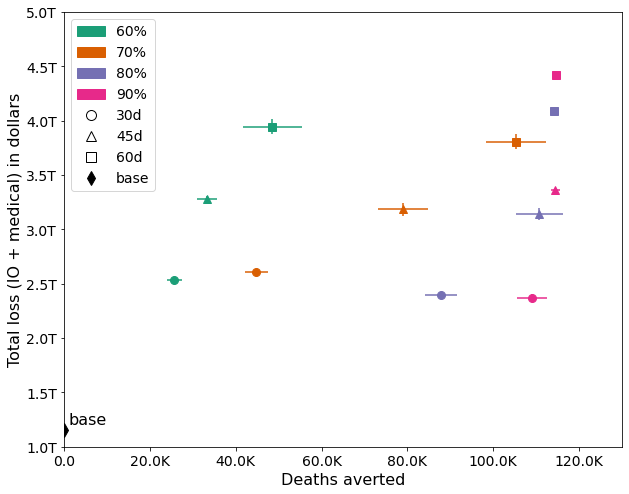

In [54]:
colors = dict(zip(['60%','70%','80%','90%'],['#1b9e77','#d95f02','#7570b3','#e7298a']))
markers = dict(zip(['30d','45d','60d'],['o','^','s']))
labels = list(loss['label'].unique()) + ['base']


#variable = 'infections'
variable = 'deaths'

plt.figure(figsize=(10,8))
ax = plt.gca()

if variable == 'deaths':
    plt.xlim([0,13*10**4])
    plt.ylim([1*10**12,5*10**12])
else:
    plt.xlim([0,125*10**6])
    plt.ylim([1*10**12,5*10**12])

if variable == 'deaths':
    for x in labels:    
        if x!='base':
            ax.errorbar(d_medians[x],l_medians[x],xerr=d_iqrs[x],yerr=l_iqrs[x],ls='',marker=markers[x.split(',')[1]],markersize=8,color=colors[x.split(',')[0]])
        else:
            ax.errorbar(d_medians[x],l_medians[x],xerr=d_iqrs[x],yerr=l_iqrs[x],color='k',marker='d',markersize=10)
            ax.text(d_medians[x]+1000,l_medians[x]*1.05,x,fontsize=16)
else:
    for x in labels:
        if x!='base':
            plt.errorbar(i_medians[x],l_medians[x],xerr=i_iqrs[x],yerr=l_iqrs[x],ls='',marker=markers[x.split(',')[1]],markersize=8,color=colors[x.split(',')[0]])
        else:
            plt.errorbar(i_medians[x],l_medians[x],xerr=i_iqrs[x],yerr=l_iqrs[x],color='k',marker='d',markersize=10)
            plt.text(i_medians[x]+1000,l_medians[x]*1.05,x,fontsize=16)
            
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))
plt.tick_params(labelsize=14)
plt.legend(handles=[mpatches.Patch(color=colors[k],label=k) for k in colors.keys()] + 
                   [mlines.Line2D([], [], color='k',marker=markers[k],linestyle='None',markersize=10,markerfacecolor='none',label=k) for k in markers.keys()] +
                   [mlines.Line2D([],[],color='k',marker='d',linestyle='None',markersize=10,label='base')],fontsize=14)
plt.xlabel('{} averted'.format(variable.title()),fontsize=16)
plt.ylabel('Total loss (IO + medical) in dollars',fontsize=16)
plt.savefig('../../fig/loss_v_{}.png'.format(variable),bbox_inches='tight',dpi=100)